AI Cognitive Classification

(Gaurav, Haosheng Ning, Linjing Xu, Milad S)

In this model customized data preprocessing not using any libraries for vectorization and tokenization.The data preprocessing step is simple and not comlplex like the other code. But the disadvantage with this code is that it is taking too much time to run. Used diffrent hyperparameters tuning to get the best parameters for each model. Models: Random forest, knn, svm linear kernel, svm rbf kernel, decision tree, logistic regression. Confusion matrix for each and othee metric evaluation. Comapring results for different models.

In [6]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score,  precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Load your dataset
df = pd.read_excel('Question.xlsx', sheet_name='Sheet2')
x = df['Questions'].values.tolist()
y = df['Label'].values.tolist()

# Text Preprocessing Function
def preprocess_text(text):
    # Convert text to lowercase and split into words
    return text.lower().split()

# Create Vocabulary Function
def create_vocabulary(sentences):
    # Create a vocabulary (unique words in all sentences)
    return set(word for sentence in sentences for word in sentence)

# Vectorize Sentence Function
def vectorize_sentence(sentence, vocabulary):
    # Create a vector representation of the sentence using the bag-of-words model
    word_counts = Counter(sentence)
    return [word_counts[word] if word in word_counts else 0 for word in vocabulary]

# Tokenize and Vectorize the Sentences
preprocessed_sentences = [preprocess_text(sentence) for sentence in x]
vocabulary = create_vocabulary(preprocessed_sentences)
X_vectorized = np.array([vectorize_sentence(sentence, vocabulary) for sentence in preprocessed_sentences])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2)


model_results = {}


Best Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.9922600619195047
              precision    recall  f1-score   support

     Analyze       1.00      0.99      0.99       218
       Apply       0.99      1.00      1.00       222
      Create       0.99      1.00      0.99       224
    Evaluate       1.00      0.99      0.99       204
    Remember       0.98      1.00      0.99       212
  Understand       1.00      0.99      0.99       212

    accuracy                           0.99      1292
   macro avg       0.99      0.99      0.99      1292
weighted avg       0.99      0.99      0.99      1292



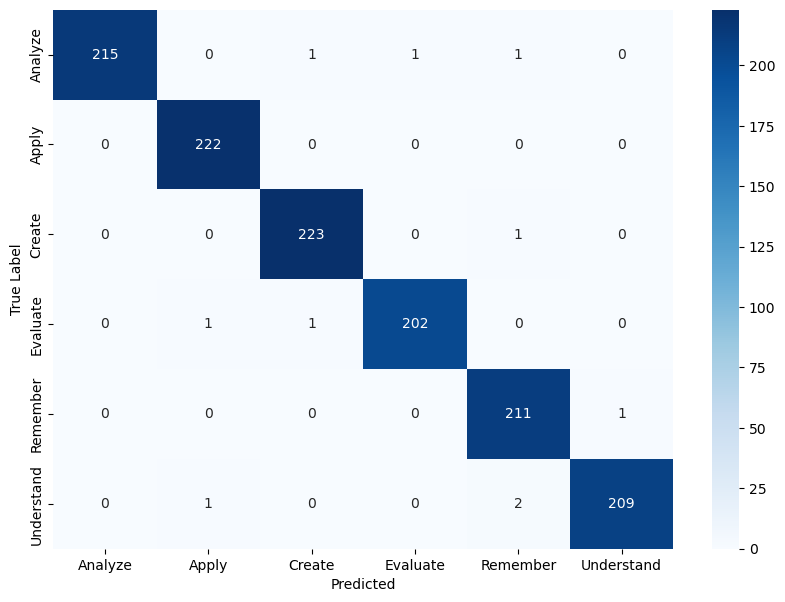

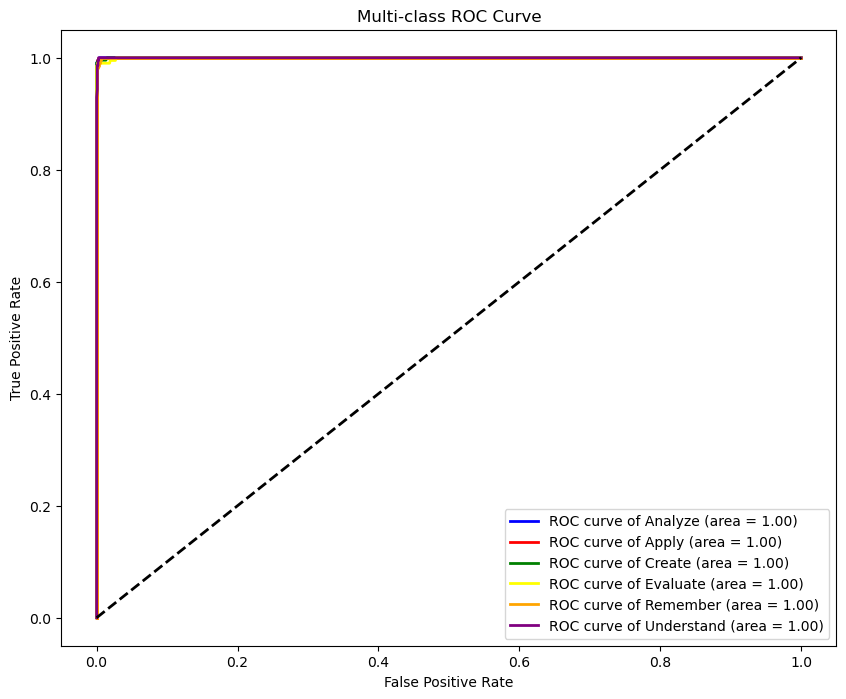

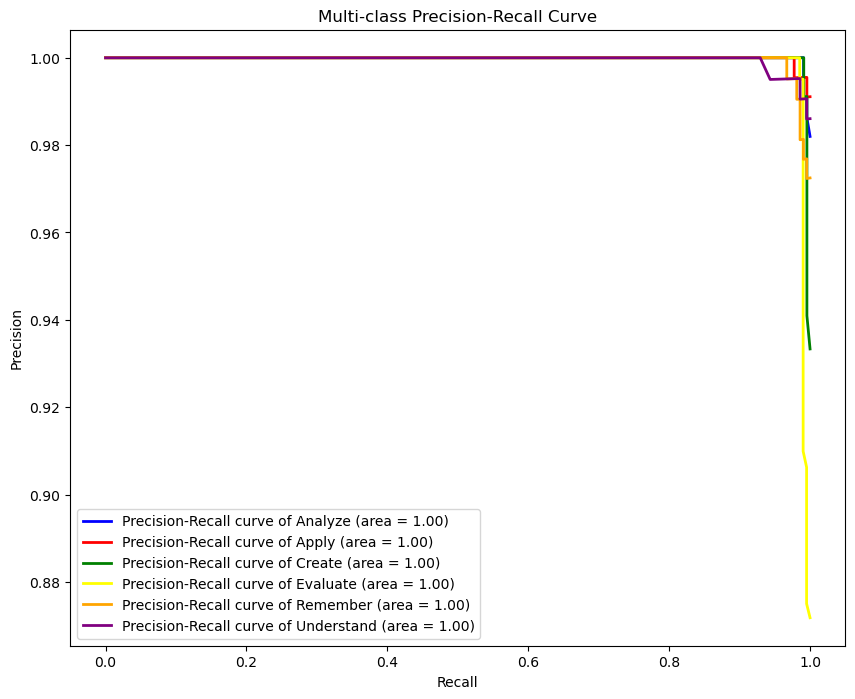

In [8]:
## Random Forest

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=0, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters: ", grid_search.best_params_)

# Train the model using the best parameters
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
# y_pred = model.predict(X_test)

RF_cm = confusion_matrix(y_test, y_pred)
RF_accuracy = accuracy_score(y_test, y_pred)
RF_recall = recall_score(y_test, y_pred, average='weighted')
RF_precision = precision_score(y_test, y_pred, average='weighted')
RF_f1 = f1_score(y_test, y_pred, average='weighted')


# Storing and printing results
model_results['Random Forest'] = {
    'Confusion Matrix': RF_cm, 
    'Accuracy': RF_accuracy, 
    'Recall': RF_recall,
    'Precision': RF_precision,
    'F1 Score': RF_f1
}


# RF_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", RF_accuracy)
print(classification_report(y_test, y_pred))

labels = sorted(set(y_test))

# Create and plot the confusion matrix
# RF_cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt="d")
sns.heatmap(RF_cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.savefig("ConfusionMatrixRF.png")
plt.show()


# Binarize the output labels for multi-class ROC and Precision-Recall curves
y_test_binarized = label_binarize(y_test, classes=sorted(set(y)))
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], best_model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], best_model.predict_proba(X_test)[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], best_model.predict_proba(X_test)[:, i])



class_names = sorted(set(y))

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'yellow', 'orange', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.savefig("ROCRF.png")
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
#     plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Precision-Recall curve of class {i} (area = {average_precision[i]:0.2f})')
      plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Precision-Recall curve of {class_names[i]} (area = {average_precision[i]:0.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-class Precision-Recall Curve')
plt.legend(loc='lower left')
plt.savefig("precisionrecallRF.png")
plt.show()

/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

Best Parameters for KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 4, 'weights': 'distance'}
KNN Accuracy: 0.9736842105263158
              precision    recall  f1-score   support

     Analyze       0.96      0.96      0.96       218
       Apply       0.98      0.99      0.98       222
      Create       0.99      0.98      0.99       224
    Evaluate       0.97      0.97      0.97       204
    Remember       0.98      0.96      0.97       212
  Understand       0.96      0.98      0.97       212

    accuracy                           0.97      1292
   macro avg       0.97      0.97      0.97      1292
weighted avg       0.97      0.97      0.97      1292



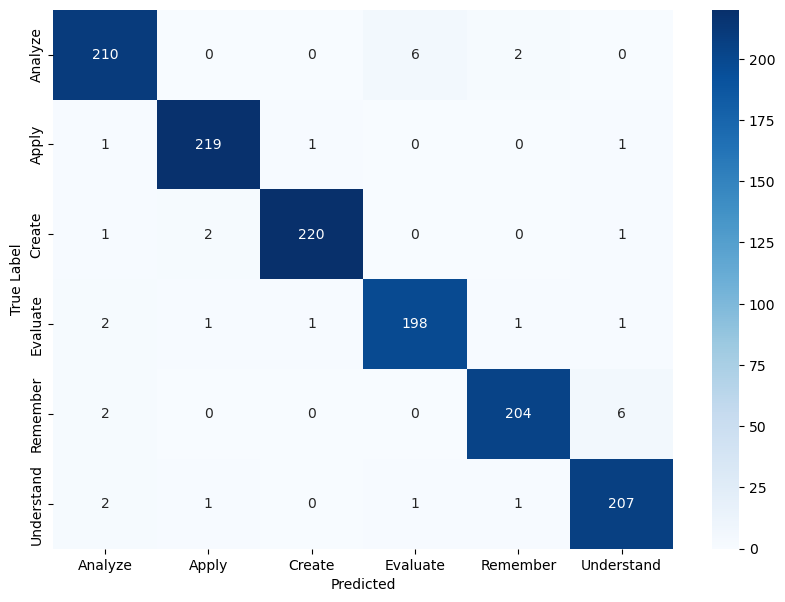

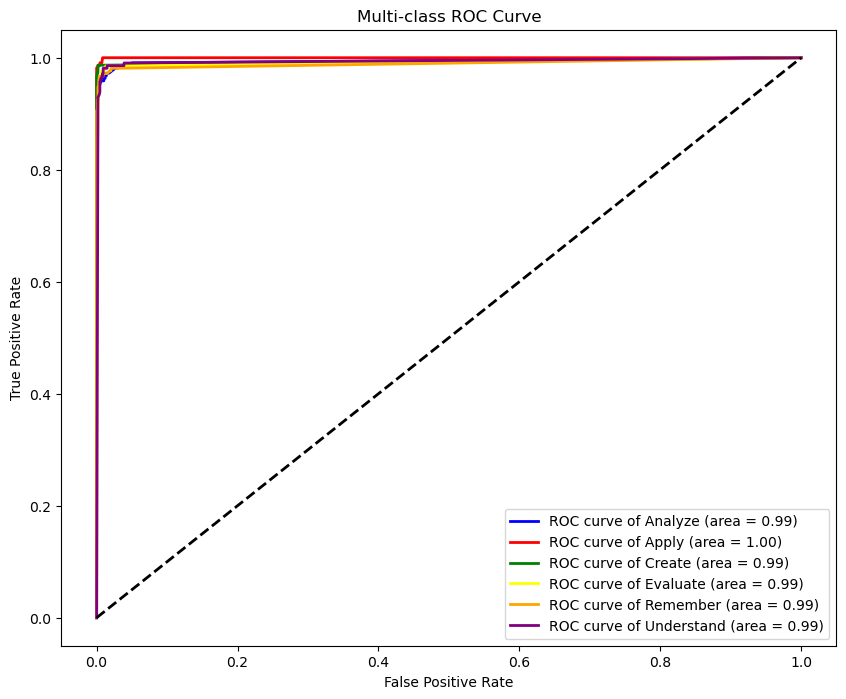

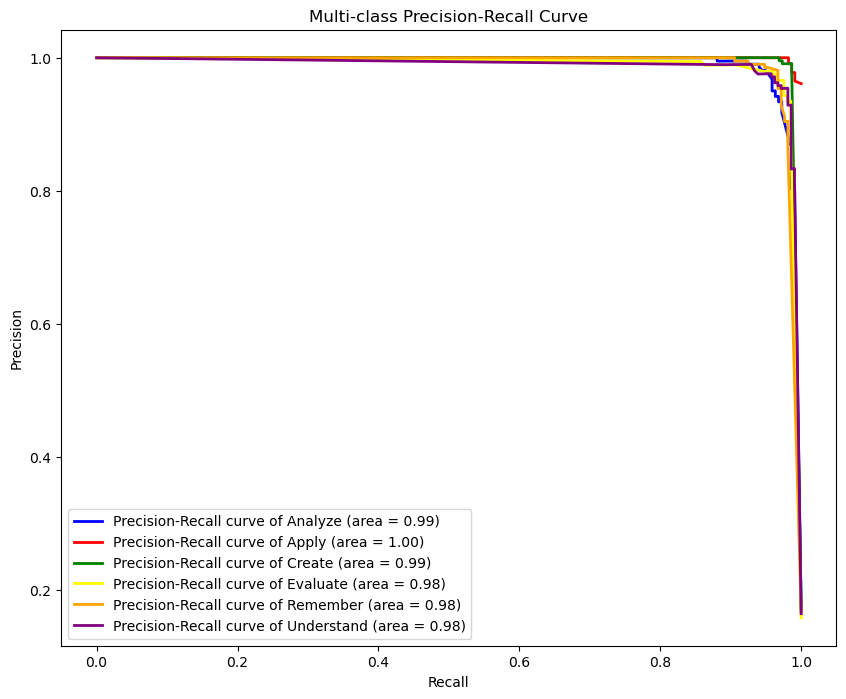

In [9]:
## KNN

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid for KNN with a range for n_neighbors
param_grid_knn = {
    'n_neighbors': list(range(3, 11)), 
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}


# Create a GridSearchCV object for KNN
grid_search_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_knn, 
                               cv=3, n_jobs=-1, verbose=0, scoring='accuracy')

# Fit the grid search to the data
grid_search_knn.fit(X_train, y_train)

# Best parameters for KNN
print("Best Parameters for KNN: ", grid_search_knn.best_params_)

# Train the KNN model using the best parameters
best_knn_model = grid_search_knn.best_estimator_

# Evaluate the best KNN model
y_pred_knn = best_knn_model.predict(X_test)

knn_cm = confusion_matrix(y_test, y_pred_knn)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_recall = recall_score(y_test, y_pred_knn, average='weighted')
knn_precision = precision_score(y_test, y_pred_knn, average='weighted')
knn_f1 = f1_score(y_test, y_pred_knn, average='weighted')


# Storing and printing results
model_results['KNN'] = {
    'Confusion Matrix': knn_cm, 
    'Accuracy': knn_accuracy, 
    'Recall': knn_recall, 
    'Precision': knn_precision,
    'F1 Score': knn_f1
}



# Accuracy and Classification Report for KNN
# knn_accuracy = accuracy_score(y_test, y_pred_knn)
print("KNN Accuracy:", knn_accuracy)
print(classification_report(y_test, y_pred_knn))

# Confusion Matrix for KNN
# knn_cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(10, 7))
sns.heatmap(knn_cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.savefig("ConfusionMatrixknn.png")
plt.show()


# Binarize the output labels for multi-class ROC and Precision-Recall curves
y_test_binarized = label_binarize(y_test, classes=sorted(set(y)))
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], best_knn_model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], best_knn_model.predict_proba(X_test)[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], best_knn_model.predict_proba(X_test)[:, i])



class_names = sorted(set(y))

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'yellow', 'orange', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.savefig("ROCknn.png")
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
#     plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Precision-Recall curve of class {i} (area = {average_precision[i]:0.2f})')
      plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Precision-Recall curve of {class_names[i]} (area = {average_precision[i]:0.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-class Precision-Recall Curve')
plt.legend(loc='lower left')
plt.savefig("precisionrecallknn.png")
plt.show()

Best Parameters for SVM:  {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
SVM Accuracy: 0.9930340557275542
              precision    recall  f1-score   support

     Analyze       1.00      1.00      1.00       218
       Apply       0.99      1.00      0.99       222
      Create       0.99      1.00      0.99       224
    Evaluate       1.00      1.00      1.00       204
    Remember       0.99      0.99      0.99       212
  Understand       0.99      0.99      0.99       212

    accuracy                           0.99      1292
   macro avg       0.99      0.99      0.99      1292
weighted avg       0.99      0.99      0.99      1292



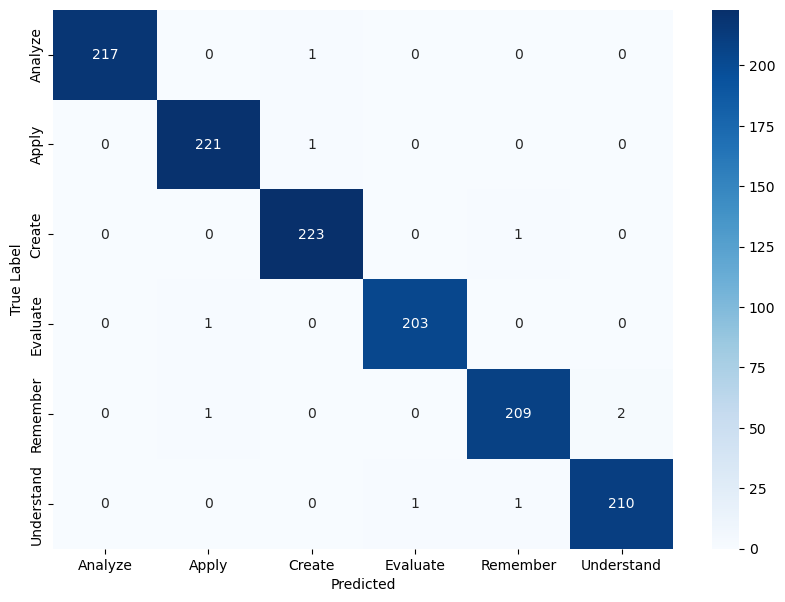

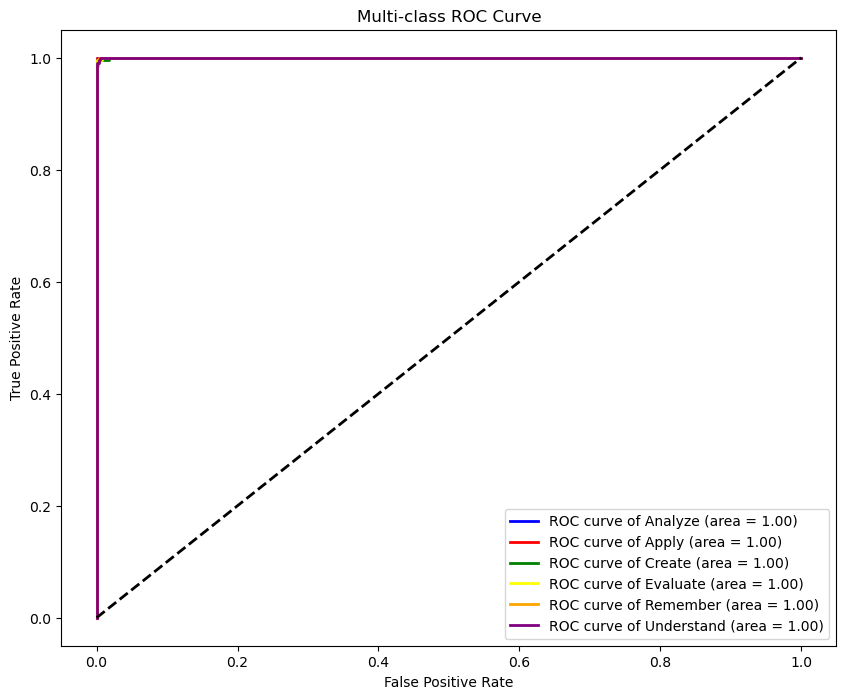

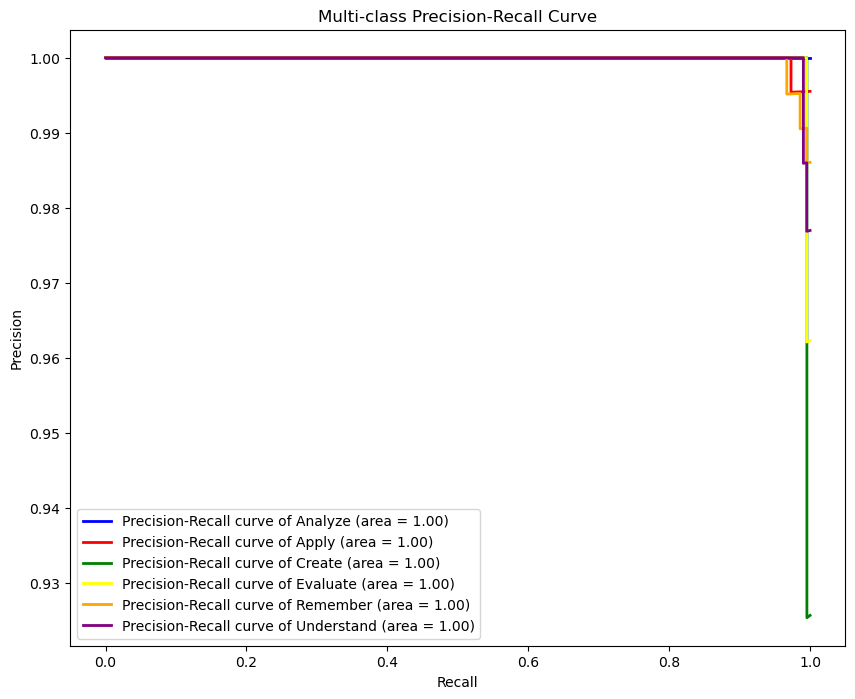

In [10]:
## SVM linear kernel

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.svm import SVC

# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'kernel': ['linear']  # Specifies the kernel type to be used in the algorithm
}


# Create a GridSearchCV object for SVM
grid_search_svm = GridSearchCV(estimator=SVC(probability=True), param_grid=param_grid_svm, 
                               cv=3, n_jobs=-1, verbose=0, scoring='accuracy')

# Fit the grid search to the data
grid_search_svm.fit(X_train, y_train)

# Best parameters for SVM
print("Best Parameters for SVM: ", grid_search_svm.best_params_)

# Train the SVM model using the best parameters
best_svm_model = grid_search_svm.best_estimator_

# Evaluate the best SVM model
y_pred_svm = best_svm_model.predict(X_test)


svm_cm = confusion_matrix(y_test, y_pred_svm)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_recall = recall_score(y_test, y_pred_svm, average='weighted')
svm_precision = precision_score(y_test, y_pred_svm, average='weighted')
svm_f1 = f1_score(y_test, y_pred_svm, average='weighted')


# Storing and printing results
model_results['SVM Linear'] = {
    'Confusion Matrix': svm_cm, 
    'Accuracy': svm_accuracy, 
    'Recall': svm_recall, 
    'Precision': svm_precision,
    'F1 Score': svm_f1
}




# Accuracy and Classification Report for SVM
# svm_accuracy = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", svm_accuracy)
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix for SVM
# svm_cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(10, 7))
sns.heatmap(svm_cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.savefig("ConfusionMatrixsvm.png")
plt.show()

# Binarize the output labels for multi-class ROC and Precision-Recall curves
y_test_binarized = label_binarize(y_test, classes=sorted(set(y)))
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], best_svm_model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], best_svm_model.predict_proba(X_test)[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], best_svm_model.predict_proba(X_test)[:, i])



class_names = sorted(set(y))

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'yellow', 'orange', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.savefig("ROCsvm.png")
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
#     plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Precision-Recall curve of class {i} (area = {average_precision[i]:0.2f})')
      plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Precision-Recall curve of {class_names[i]} (area = {average_precision[i]:0.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-class Precision-Recall Curve')
plt.legend(loc='lower left')
plt.savefig("precisionrecallSVM.png")
plt.show()




Best Parameters for SVM (RBF):  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
SVM (RBF) Accuracy: 0.9914860681114551
              precision    recall  f1-score   support

     Analyze       1.00      1.00      1.00       218
       Apply       0.99      1.00      1.00       222
      Create       0.98      1.00      0.99       224
    Evaluate       1.00      0.99      0.99       204
    Remember       0.99      0.98      0.98       212
  Understand       1.00      0.99      0.99       212

    accuracy                           0.99      1292
   macro avg       0.99      0.99      0.99      1292
weighted avg       0.99      0.99      0.99      1292



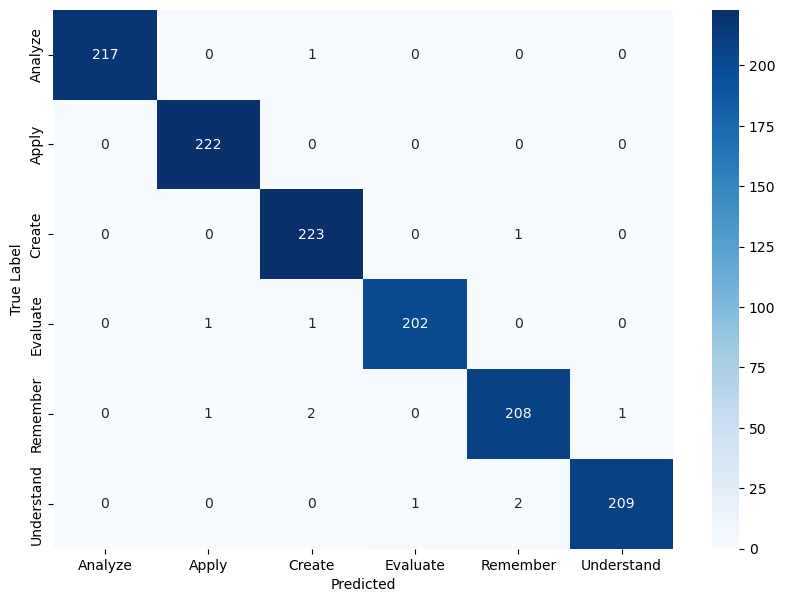

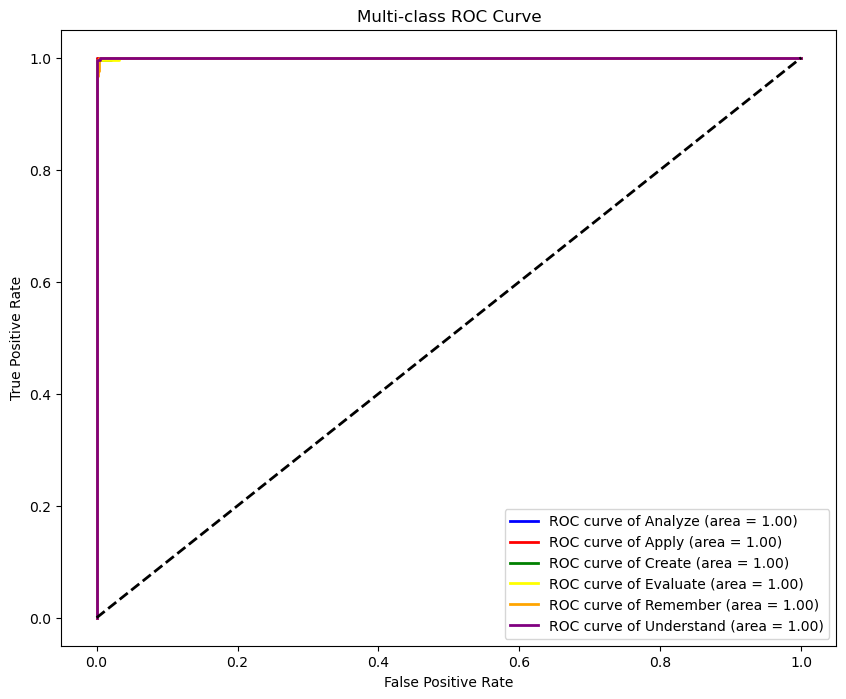

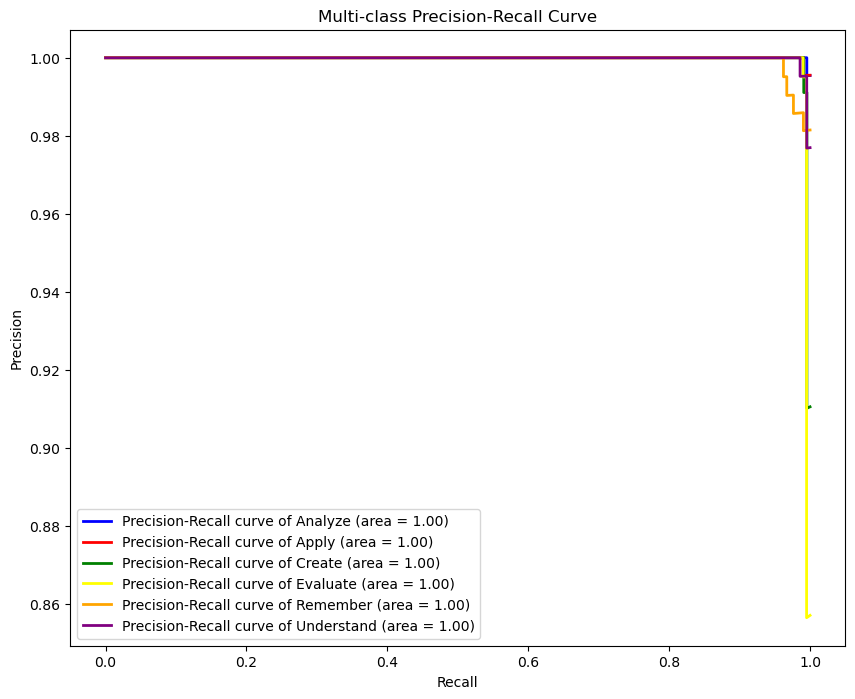

In [11]:
## SVM RBF kernel

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle


# Define the parameter grid for SVM with RBF kernel
param_grid_svm_rbf = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.1, 1, 10, 100],  # Kernel coefficient
    'kernel': ['rbf']  # Specifies the RBF kernel to be used in the algorithm
}

# Create a GridSearchCV object for SVM with RBF kernel
grid_search_svm_rbf = GridSearchCV(estimator=SVC(probability = True), param_grid=param_grid_svm_rbf, 
                                   cv=3, n_jobs=-1, verbose=0, scoring='accuracy')

# Fit the grid search to the data
grid_search_svm_rbf.fit(X_train, y_train)

# Best parameters for SVM with RBF kernel
print("Best Parameters for SVM (RBF): ", grid_search_svm_rbf.best_params_)

# Train the SVM model using the best parameters
best_svm_rbf_model = grid_search_svm_rbf.best_estimator_

# Evaluate the best SVM model
y_pred_svm_rbf = best_svm_rbf_model.predict(X_test)

svm_rbf_cm = confusion_matrix(y_test, y_pred_svm_rbf)
svm_rbf_accuracy = accuracy_score(y_test, y_pred_svm_rbf)
svm_rbf_recall = recall_score(y_test, y_pred_svm_rbf, average='weighted')
svm_rbf_precision = precision_score(y_test, y_pred_svm_rbf, average='weighted')
svm_rbf_f1 = f1_score(y_test, y_pred_svm_rbf, average='weighted')


# Storing and printing results
model_results['SVM RBF'] = {
    'Confusion Matrix': svm_rbf_cm, 
    'Accuracy': svm_rbf_accuracy, 
    'Recall': svm_rbf_recall, 
    'Precision': svm_rbf_precision,
    'F1 Score': svm_rbf_f1
}

# Accuracy and Classification Report for SVM with RBF kernel
# svm_rbf_accuracy = accuracy_score(y_test, y_pred_svm_rbf)
print("SVM (RBF) Accuracy:", svm_rbf_accuracy)
print(classification_report(y_test, y_pred_svm_rbf))

# Confusion Matrix for SVM with RBF kernel
# svm_rbf_cm = confusion_matrix(y_test, y_pred_svm_rbf)
plt.figure(figsize=(10, 7))
sns.heatmap(svm_rbf_cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.savefig("ConfusionMatrixrbf.png")
plt.show()

# Binarize the output labels for multi-class ROC and Precision-Recall curves
y_test_binarized = label_binarize(y_test, classes=sorted(set(y)))
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], best_svm_rbf_model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], best_svm_rbf_model.predict_proba(X_test)[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], best_svm_rbf_model.predict_proba(X_test)[:, i])



class_names = sorted(set(y))

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'yellow', 'orange', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.savefig("ROCrbf.png")
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
#     plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Precision-Recall curve of class {i} (area = {average_precision[i]:0.2f})')
      plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Precision-Recall curve of {class_names[i]} (area = {average_precision[i]:0.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-class Precision-Recall Curve')
plt.legend(loc='lower left')
plt.savefig("precisionrecallrbf.png")
plt.show()





Best Parameters for Decision Tree:  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree Accuracy: 0.9574303405572755
              precision    recall  f1-score   support

     Analyze       0.93      0.97      0.95       218
       Apply       0.97      0.97      0.97       222
      Create       0.96      0.96      0.96       224
    Evaluate       1.00      0.97      0.99       204
    Remember       0.94      0.96      0.95       212
  Understand       0.95      0.91      0.93       212

    accuracy                           0.96      1292
   macro avg       0.96      0.96      0.96      1292
weighted avg       0.96      0.96      0.96      1292



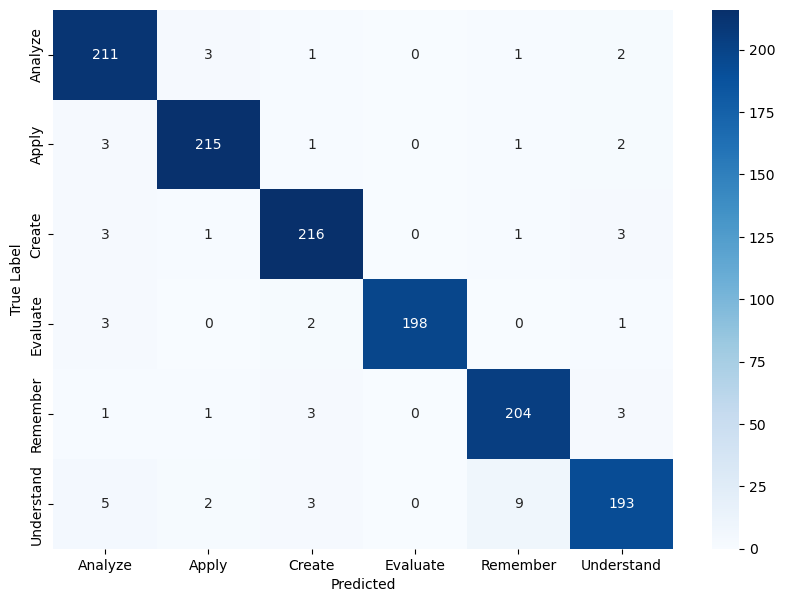

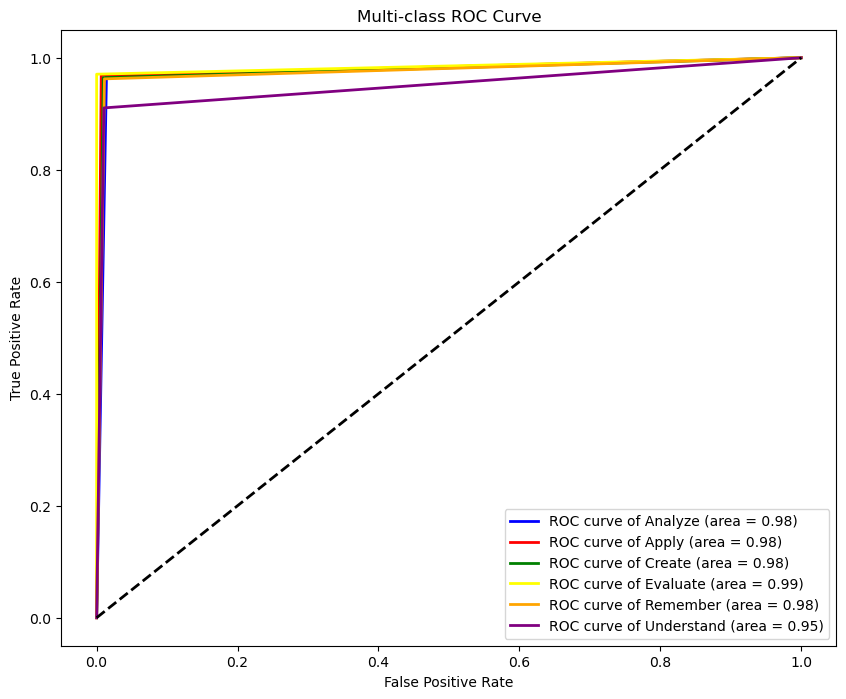

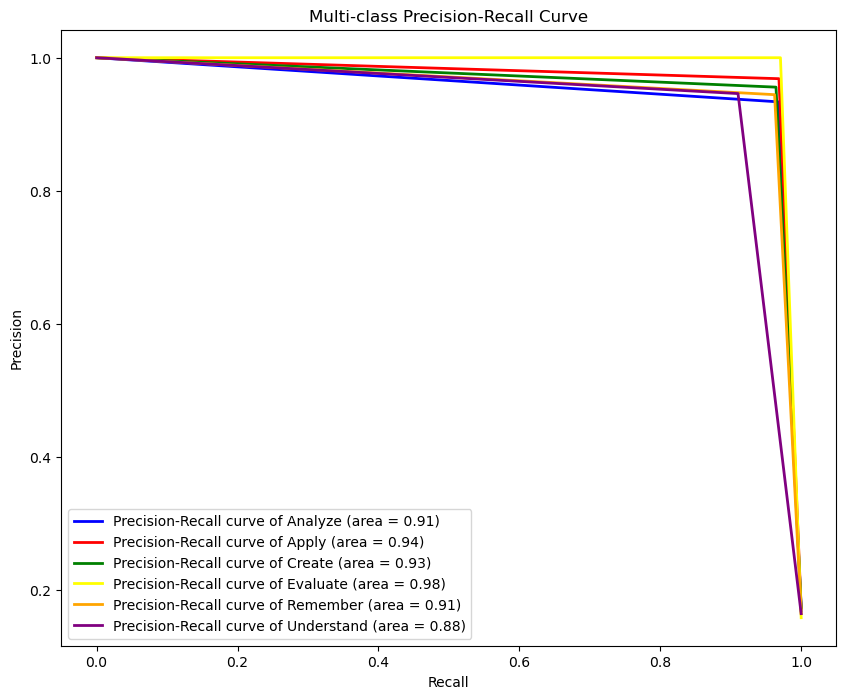

In [12]:
## Decision Tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle

# Define the parameter grid for Decision Tree
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object for Decision Tree
grid_search_dt = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid_dt, 
                              cv=3, n_jobs=-1, verbose=0, scoring='accuracy')

# Fit the grid search to the data
grid_search_dt.fit(X_train, y_train)

# Best parameters for Decision Tree
print("Best Parameters for Decision Tree: ", grid_search_dt.best_params_)

# Train the Decision Tree model using the best parameters
best_dt_model = grid_search_dt.best_estimator_

# Evaluate the best Decision Tree model
y_pred_dt = best_dt_model.predict(X_test)

dt_cm = confusion_matrix(y_test, y_pred_dt)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt, average='weighted')
dt_precision = precision_score(y_test, y_pred_dt, average='weighted')
dt_f1 = f1_score(y_test, y_pred_dt, average='weighted')


# Storing and printing results
model_results['Decision Tree'] = {
    'Confusion Matrix': dt_cm, 
    'Accuracy': dt_accuracy, 
    'Recall': dt_recall,
    'Precision': dt_precision,
    'F1 Score': dt_f1
}

# Accuracy and Classification Report for Decision Tree
# dt_accuracy = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", dt_accuracy)
print(classification_report(y_test, y_pred_dt))

# Confusion Matrix for Decision Tree
# dt_cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(10, 7))
sns.heatmap(dt_cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.savefig("ConfusionMatrixdt.png")
plt.show()

# Binarize the output labels for multi-class ROC and Precision-Recall curves
y_test_binarized = label_binarize(y_test, classes=sorted(set(y)))
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], best_dt_model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], best_dt_model.predict_proba(X_test)[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], best_dt_model.predict_proba(X_test)[:, i])



class_names = sorted(set(y))

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'yellow', 'orange', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.savefig("ROCdt.png")
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
#     plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Precision-Recall curve of class {i} (area = {average_precision[i]:0.2f})')
      plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Precision-Recall curve of {class_names[i]} (area = {average_precision[i]:0.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-class Precision-Recall Curve')
plt.legend(loc='lower left')
plt.savefig("precisionrecallDT.png")
plt.show()


Best Parameters for Logistic Regression:  {'C': 100, 'max_iter': 100, 'solver': 'liblinear'}
Logistic Regression Accuracy: 0.9914860681114551
              precision    recall  f1-score   support

     Analyze       0.99      1.00      0.99       218
       Apply       0.99      0.99      0.99       222
      Create       0.99      1.00      0.99       224
    Evaluate       1.00      1.00      1.00       204
    Remember       0.99      0.99      0.99       212
  Understand       0.99      0.99      0.99       212

    accuracy                           0.99      1292
   macro avg       0.99      0.99      0.99      1292
weighted avg       0.99      0.99      0.99      1292



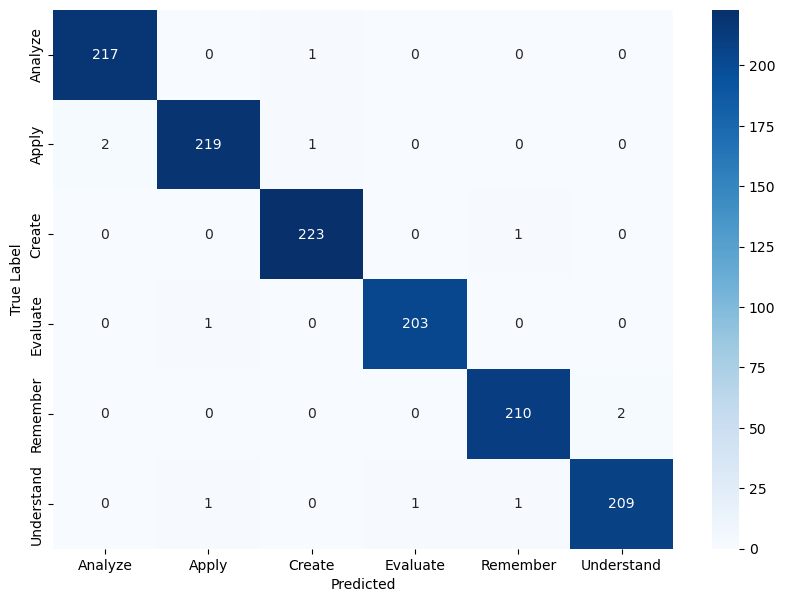

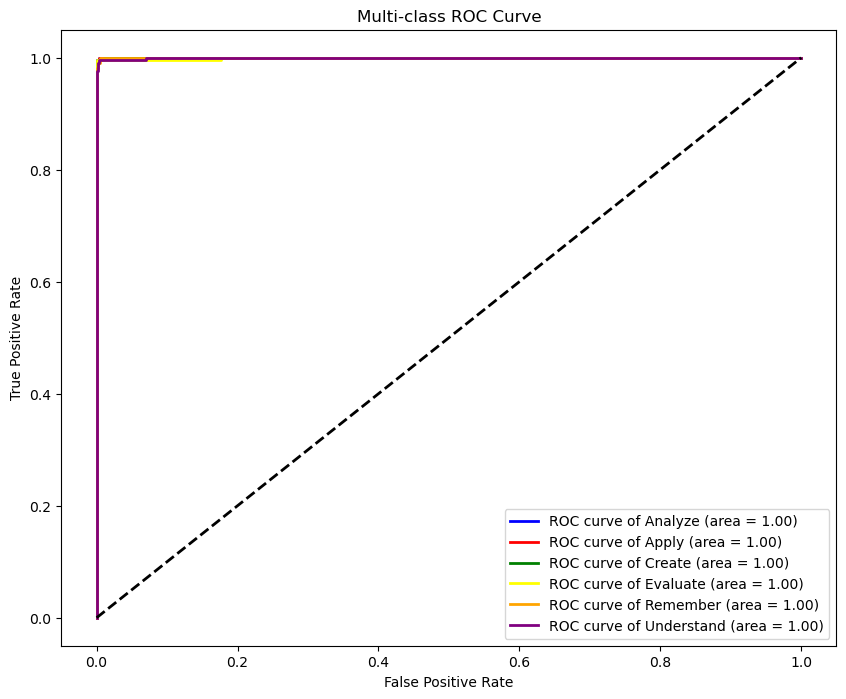

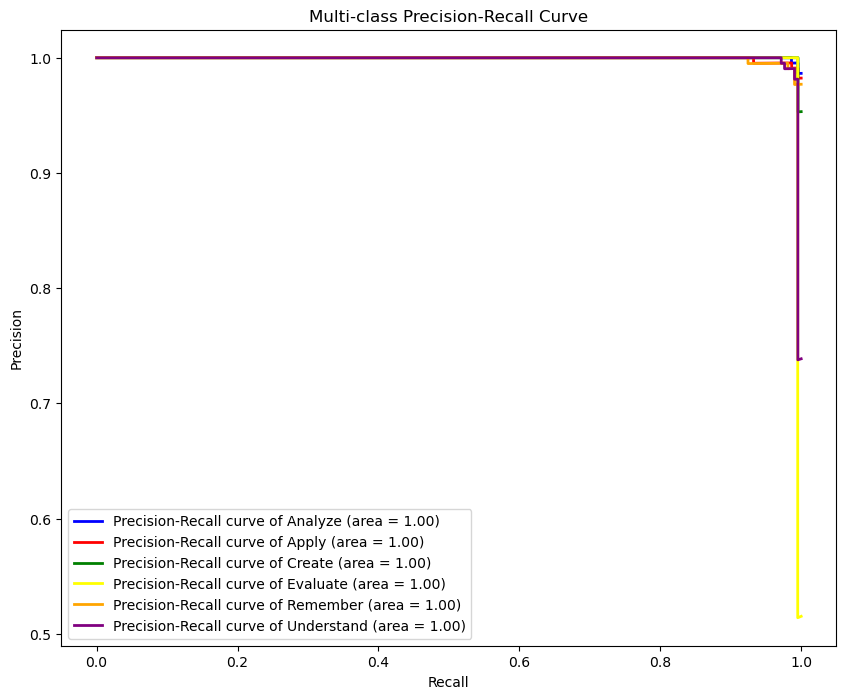

In [13]:
## Logistic Regression

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint


# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'solver': ['newton-cg', 'liblinear'],  # Algorithm to use in the optimization problem
    'max_iter': [100, 200, 500, 1000, 5000, 10000]
}

# Create a GridSearchCV object for Logistic Regression
grid_search_lr = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid_lr, 
                              cv=3, n_jobs=-1, verbose=0, scoring='accuracy')

# Fit the grid search to the data
grid_search_lr.fit(X_train, y_train)

# Best parameters for Logistic Regression
print("Best Parameters for Logistic Regression: ", grid_search_lr.best_params_)

# Train the Logistic Regression model using the best parameters
best_lr_model = grid_search_lr.best_estimator_

# Evaluate the best Logistic Regression model
y_pred_lr = best_lr_model.predict(X_test)

lr_cm = confusion_matrix(y_test, y_pred_lr)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr, average='weighted')
lr_precision = precision_score(y_test, y_pred_lr, average='weighted')
lr_f1 = f1_score(y_test, y_pred_lr, average='weighted')


# Storing and printing results
model_results['Logistic Regression'] = {
    'Confusion Matrix': lr_cm, 
    'Accuracy': lr_accuracy, 
    'Recall': lr_recall,
    'Precision': lr_precision,
    'F1 Score': lr_f1
}

# Accuracy and Classification Report for Logistic Regression
# lr_accuracy = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", lr_accuracy)
print(classification_report(y_test, y_pred_lr))

labels = sorted(set(y_test))

# Confusion Matrix for Logistic Regression
# lr_cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(10, 7))
sns.heatmap(lr_cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.savefig("ConfusionMatrixLR.png")
plt.show()

# Binarize the output labels for multi-class ROC and Precision-Recall curves
y_test_binarized = label_binarize(y_test, classes=sorted(set(y)))
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], best_lr_model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], best_lr_model.predict_proba(X_test)[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], best_lr_model.predict_proba(X_test)[:, i])



class_names = sorted(set(y))

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'yellow', 'orange', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.savefig("ROClr.png")
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
#     plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Precision-Recall curve of class {i} (area = {average_precision[i]:0.2f})')
      plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Precision-Recall curve of {class_names[i]} (area = {average_precision[i]:0.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-class Precision-Recall Curve')
plt.legend(loc='lower left')
plt.savefig("precisionrecalllr.png")
plt.show()


                                                      Confusion Matrix  \
Random Forest        [[215, 0, 1, 1, 1, 0], [0, 222, 0, 0, 0, 0], [...   
KNN                  [[210, 0, 0, 6, 2, 0], [1, 219, 1, 0, 0, 1], [...   
SVM Linear           [[217, 0, 1, 0, 0, 0], [0, 221, 1, 0, 0, 0], [...   
SVM RBF              [[217, 0, 1, 0, 0, 0], [0, 222, 0, 0, 0, 0], [...   
Decision Tree        [[211, 3, 1, 0, 1, 2], [3, 215, 1, 0, 1, 2], [...   
Logistic Regression  [[217, 0, 1, 0, 0, 0], [2, 219, 1, 0, 0, 0], [...   

                     Accuracy    Recall Precision  F1 Score  
Random Forest         0.99226   0.99226  0.992313  0.992261  
KNN                  0.973684  0.973684   0.97378  0.973699  
SVM Linear           0.993034  0.993034  0.993041  0.993034  
SVM RBF              0.991486  0.991486  0.991519  0.991485  
Decision Tree         0.95743   0.95743  0.957748  0.957429  
Logistic Regression  0.991486  0.991486  0.991486  0.991482  


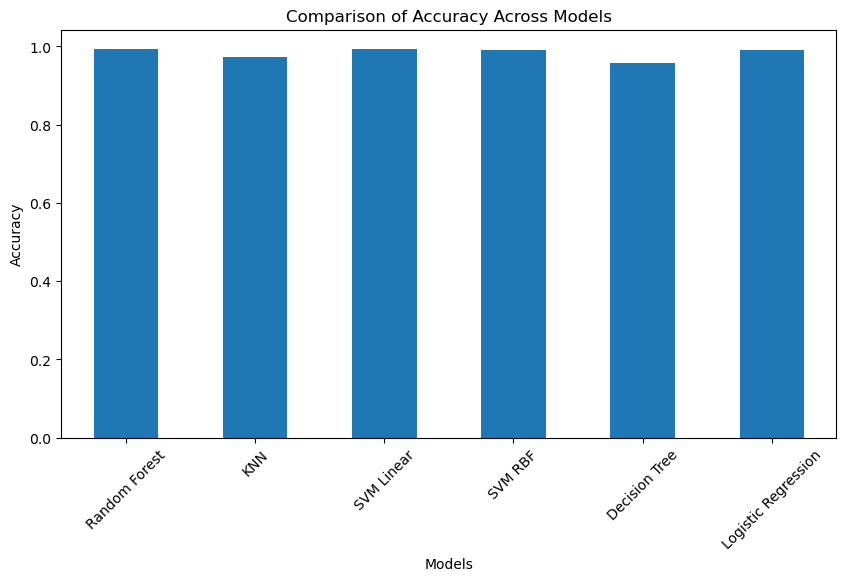

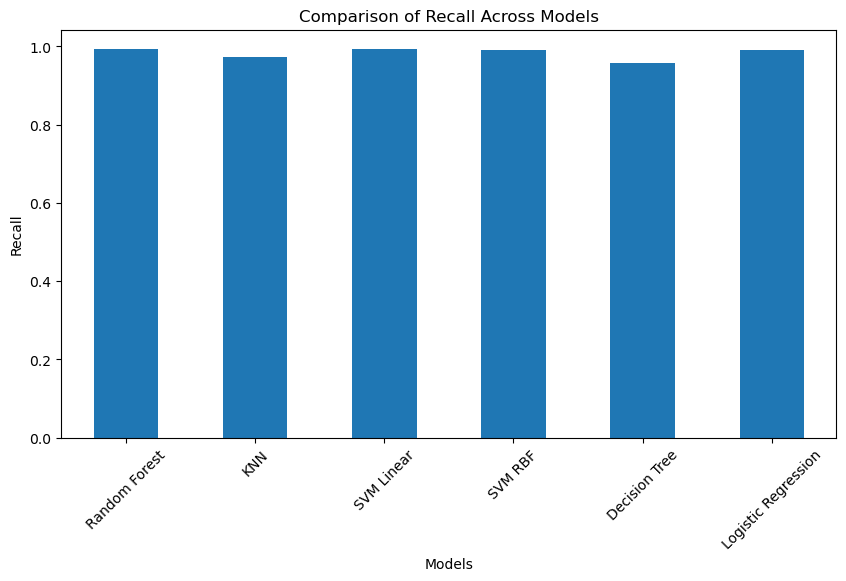

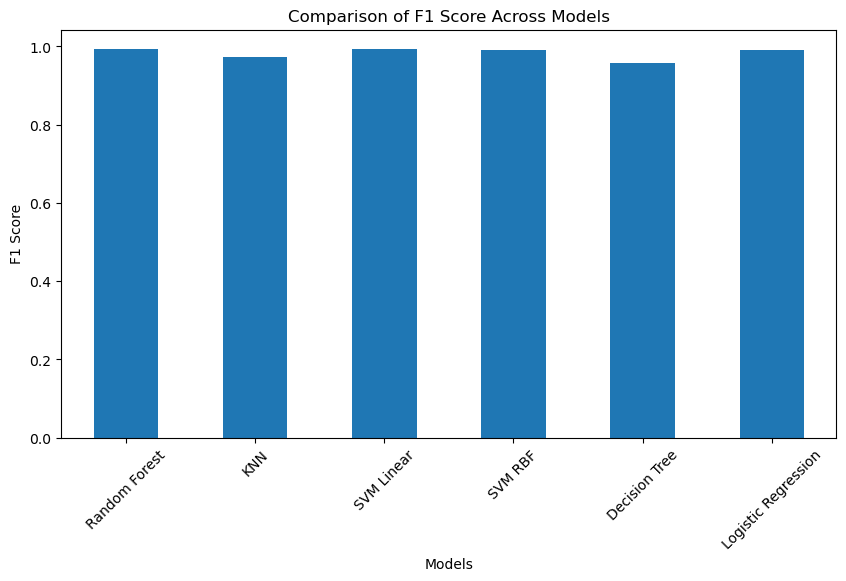

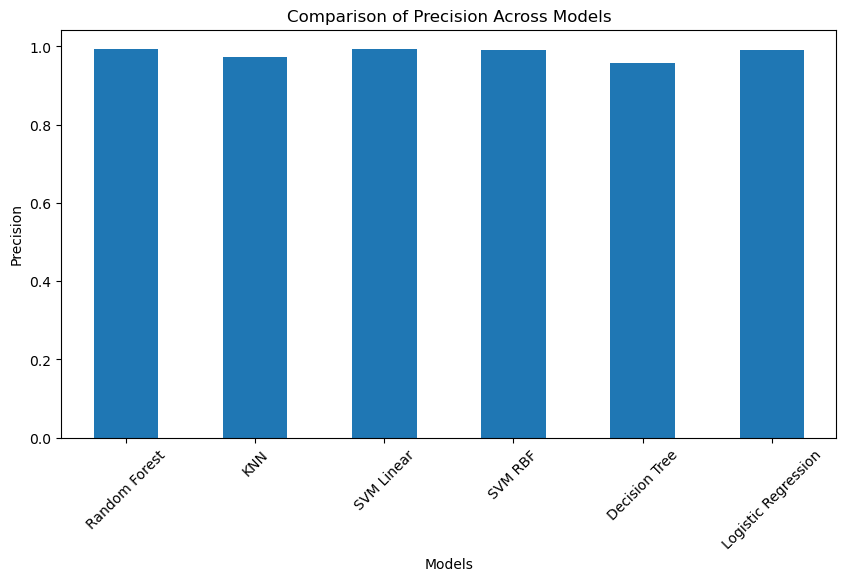

In [14]:
# Convert the model results into a DataFrame
df_results = pd.DataFrame(model_results).T

# Print the DataFrame for a tabular comparison
print(df_results)

# Plotting the results for comparison
# Bar plot for each metric
metrics = ['Accuracy', 'Recall', 'F1 Score', 'Precision']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    df_results[metric].plot(kind='bar')
    plt.title(f'Comparison of {metric} Across Models')
    plt.ylabel(metric)
    plt.xlabel('Models')
    plt.xticks(rotation=45)
    plt.subplots_adjust(bottom=0.20)
    plt.savefig(f"Comparison_{metric}.png")
    plt.show()

In [16]:
from sklearn.metrics import cohen_kappa_score


models = {'RandomForest': best_model, 'KNN': best_knn_model, 'SVM Linear': best_svm_model, 'SVM RBF': best_svm_rbf_model, 'Decision Tree': best_dt_model, 'Logistic Regression': best_lr_model}
 
# Generate predictions from each model
predictions = {model_name: model.predict(X_test) for model_name, model in models.items()}

# Calculate Cohen's Kappa for each pair of models
kappa_scores = {}
for model1_name, preds1 in predictions.items():
    for model2_name, preds2 in predictions.items():
        if model1_name < model2_name:  # This ensures each pair is only compared once
            kappa = cohen_kappa_score(preds1, preds2)
            kappa_scores[(model1_name, model2_name)] = kappa

# Displaying the kappa scores
for model_pair, kappa in kappa_scores.items():
    print(f"Cohen's Kappa between {model_pair[0]} and {model_pair[1]}: {kappa}")


Cohen's Kappa between RandomForest and SVM Linear: 0.9897809431703379
Cohen's Kappa between RandomForest and SVM RBF: 0.9916386468816784
Cohen's Kappa between KNN and RandomForest: 0.9721310874268495
Cohen's Kappa between KNN and SVM Linear: 0.9674858478593651
Cohen's Kappa between KNN and SVM RBF: 0.9656271548640337
Cohen's Kappa between KNN and Logistic Regression: 0.9684152324170962
Cohen's Kappa between SVM Linear and SVM RBF: 0.9934967767914604
Cohen's Kappa between Decision Tree and RandomForest: 0.9498296445763119
Cohen's Kappa between Decision Tree and KNN: 0.9321826716213574
Cohen's Kappa between Decision Tree and SVM Linear: 0.9470434688814583
Cohen's Kappa between Decision Tree and SVM RBF: 0.9479699866674529
Cohen's Kappa between Decision Tree and Logistic Regression: 0.947971782573366
Cohen's Kappa between Logistic Regression and RandomForest: 0.9897810386928473
Cohen's Kappa between Logistic Regression and SVM Linear: 0.9962840274297449
Cohen's Kappa between Logistic Regr

The Cohen's Kappa scores indicate a remarkably high level of agreement among various machine learning models in classification task, revealing some intriguing insights. The scores are particularly noteworthy between Logistic Regression and SVM Linear, with an almost perfect kappa score of 0.996, suggesting these models, despite their algorithmic differences, are making nearly identical predictions. This could be indicative of a linearly separable nature of dataset, where both linear models perform exceptionally well.

Similarly, RandomForest's agreement with both SVM Linear and RBF, as well as Logistic Regression, is very high, with kappa scores just shy of 0.99. This suggests a strong alignment in the decision-making process of these models, despite their inherent differences in algorithmic approach. It's quite significant given RandomForest's ensemble nature and the kernel-based methodology of SVMs.

The Decision Tree classifier also shows a high degree of agreement with RandomForest, SVMs, and Logistic Regression, with kappa values ranging between 0.947 and 0.950. Typically, Decision Trees might show more variance compared to these models, so such high agreement is noteworthy and suggests that the Decision Tree is capturing patterns similar to more complex models.

However, the Decision Tree's agreement with KNN is slightly lower, though still substantial, at a kappa score of 0.932. This could reflect the contrasting nature of how KNN (a distance-based algorithm) and Decision Trees categorize data.

